# **WMM Lab 5**

---

Wykonano przez: Marfenko Mykhailo 323558 / Number obrazu: 26 (peppers)

In [67]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import Image, display
import os

In [68]:
img_mono_path = "obrazy/mono/peppers_mono.png"
img_col_path = "obrazy/color/peppers_col.png"
img_output_path = "output.png"

In [69]:
def cv_imshow(img, img_title="image"):
    if (img.dtype == np.float32) or (img.dtype == np.float64):
        img_ = img / 255
    elif img.dtype == np.int16:
        img_ = img*128
    else:
        img_ = img
    if img.dtype == np.int16:
        img_ = np.uint8((img + 255) // 2)

    cv2.imwrite(img_output_path, img_)
    display(Image(filename=img_output_path))
    return


def show_img(img, mono=False):
    if img.dtype == np.int16:
        img = (img + 255) // 2
    if mono:
        plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    else:
        plt.imshow(img)
    plt.xticks([])
    plt.yticks([])


def calc_entropy(hist):
    pdf = hist/hist.sum() ### normalizacja histogramu -> rozkład prawdopodobieństwa; UWAGA: niebezpieczeństwo '/0' dla 'zerowego' histogramu!!!
    # entropy = -(pdf*np.log2(pdf)).sum() ### zapis na tablicach, ale problem z '/0'
    entropy = -sum([x*np.log2(x) for x in pdf if x != 0])
    return entropy


def dwt(img):
    """
    Bardzo prosta i podstawowa implementacja, nie uwzględniająca efektywnych metod obliczania DWT
    i dopuszczająca pewne niedokładności.
    """
    maskL = np.array([0.02674875741080976, -0.01686411844287795, -0.07822326652898785, 0.2668641184428723,
        0.6029490182363579, 0.2668641184428723, -0.07822326652898785, -0.01686411844287795, 0.02674875741080976])
    maskH = np.array([0.09127176311424948, -0.05754352622849957, -0.5912717631142470, 1.115087052456994,
        -0.5912717631142470, -0.05754352622849957, 0.09127176311424948])

    bandLL = cv2.sepFilter2D(img,         -1, maskL, maskL)[::2, ::2]
    bandLH = cv2.sepFilter2D(img, cv2.CV_16S, maskL, maskH)[::2, ::2] ### ze względu na filtrację górnoprzepustową -> wartości ujemne, dlatego wynik 16-bitowy ze znakiem
    bandHL = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskL)[::2, ::2]
    bandHH = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskH)[::2, ::2]

    return bandLL, bandLH, bandHL, bandHH


def calc_mse_psnr(img1, img2):
    """ Funkcja obliczająca MSE i PSNR dla różnicy podanych obrazów, zakładana wartość pikseli z przedziału [0, 255]. """

    imax = 255.**2 ### maksymalna wartość sygnału -> 255
    """
    W różnicy obrazów istotne są wartości ujemne, dlatego img1 konwertowany jest do typu np.float64 (liczby rzeczywiste) 
    aby nie ograniczać wyniku do przedziału [0, 255].
    """
    mse = ((img1.astype(np.float64)-img2)**2).sum()/img1.size ###img1.size - liczba elementów w img1, ==img1.shape[0]*img1.shape[1] dla obrazów mono, ==img1.shape[0]*img1.shape[1]*img1.shape[2] dla obrazów barwnych
    psnr = 10.0*np.log10(imax/mse)
    return (mse, psnr)


def printi(img, img_title=""):
    """ Pomocnicza funkcja do wypisania informacji o obrazie. """
    print(f"{img_title}, wymiary: {img.shape}, typ danych: {img.dtype}, wartości: {img.min()} - {img.max()}")

---

## Obraz monochromatyczny

>Obliczyć przepływność (liczbę bitów przypadającą na jeden piksel) dla obrazu skompresowanego koderem PNG (obraz wejściowy)

In [70]:
img_mono = cv2.imread(img_mono_path, cv2.IMREAD_UNCHANGED)
printi(img_mono, "image_mono")
bitrate = 8*os.stat(img_mono_path).st_size/(img_mono.shape[0]*img_mono.shape[1])
print(f"bitrate: {bitrate:.4f}")

image_mono, wymiary: (512, 512), typ danych: uint8, wartości: 0 - 227
bitrate: 5.2806


>Obliczyć entropię obrazu i porównać ją z wyliczoną przepływnością

In [71]:
hist_image = cv2.calcHist([img_mono], [0], None, [256], [0, 256])
""" 
cv2.calcHist() zwraca histogram w postaci tablicy 2D, 
do dalszego przetwarzania wygodniejsza może być tablica jednowymiarowa -> flatten().
"""
hist_image = hist_image.flatten()
# print(hist_image.sum(), 512*512) ### dla sprawdzenia: suma wartości histogramu powinna być równa liczbie pikseli w obrazie

H_image = calc_entropy(hist_image)
print(f"H(image) = {H_image:.4f}")

H(image) = 7.5935


>Czy przepływność mniejsza od entropii oznacza, że zależność: l<sub>śr</sub> ≥ H jest nieprawdziwa?

Nie, bo mamy doczynienie z obrazem .png, co oznacza, że brana jest pod uwagę korelacja pomiędzy pikselami.

>Wyznaczyć obraz różnicowy w taki sposób, że wartość każdego piksela zastępowana jest różnicą pomiędzy wartością tego piksela a wartością jego lewego sąsiada (kodowanie różnicowe /. predykcyjne). Dla pierwszego piksela w linii należy przyjąć wartość sąsiada równą 127 (środkowa wartość przedziału zmienności wartości pikseli). Wyświetlić obraz różnicowy.

image_hdiff, wymiary: (512, 511), typ danych: int16, wartości: -132 - 187
image_hdiff_0, wymiary: (512, 1), typ danych: int16, wartości: -126 - -62
image_hdiff, wymiary: (512, 512), typ danych: int16, wartości: -132 - 187


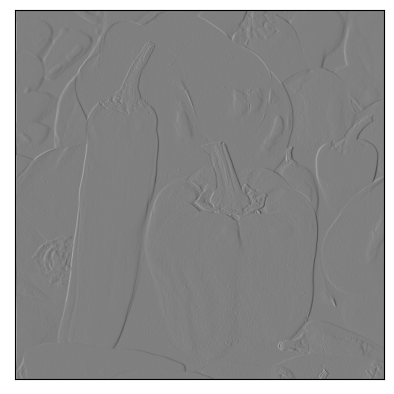

In [72]:
img_tmp1 = img_mono[:, 1:]  ### wszystkie wiersze (':'), kolumny od 'pierwszej' do ostatniej ('1:')
img_tmp2 = img_mono[:, :-1] ### wszystkie wiersze, kolumny od 'zerowej' do przedostatniej (':-1')

"""
W wyniku odejmowania pojawią się wartości ujemne - zakres wartości pikseli w obrazie różnicowym to będzie [-255, 255],
dlatego trzeba zminić typ wartości pikseli, żeby zakres wartości nie ograniczał się do [0, 255];
może to być np. cv2.CV_16S (odpowiednio np.int16 w NumPy), żeby pozostać w domenie liczb całkowitych.
"""
image_hdiff = cv2.addWeighted(img_tmp1, 1, img_tmp2, -1, 0, dtype=cv2.CV_16S)
printi(image_hdiff, "image_hdiff")
"""  
image_hdiff ma o jedną kolumnę mniej - dla skrajnie lewej kolumny nie było danych do odejmowania,
kolumnę tę można potraktować oddzielnie i 'połączyć' wyniki.
"""
image_hdiff_0 = cv2.addWeighted(img_mono[:, 0], 1, 0, 0, -127, dtype=cv2.CV_16S) ### od 'zerowej' kolumny obrazu oryginalnego odejmowana stała wartość '127'
printi(image_hdiff_0, "image_hdiff_0")
image_hdiff = np.hstack((image_hdiff_0, image_hdiff)) ### połączenie tablic w kierunku poziomym, czyli 'kolumna za kolumną'
printi(image_hdiff, "image_hdiff")

show_img(image_hdiff, True)

>Wyznaczyć histogram obrazu różnicowego i porównać go z histogramem obrazu oryginalnego. Wyznaczyć entropię obrazu różnicowego i porównać ją z entropią obrazu oryginalnego.

<Figure size 640x480 with 0 Axes>

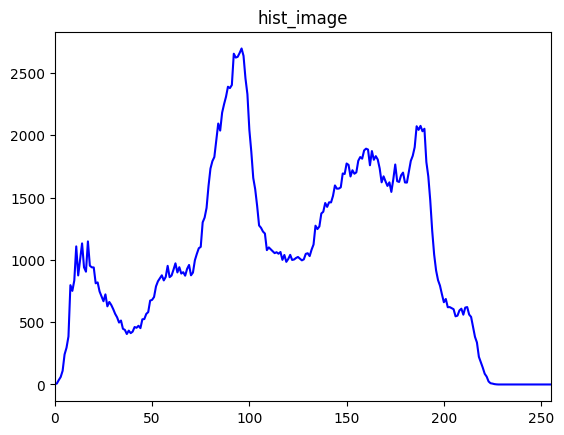

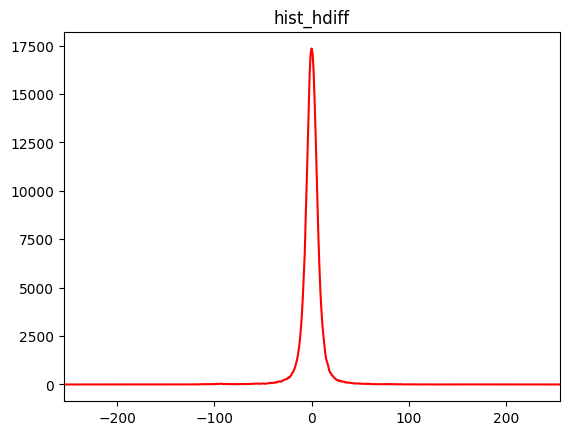

<Figure size 640x480 with 0 Axes>

In [73]:
image_tmp = (image_hdiff+255).astype(np.uint16)
hist_hdiff = cv2.calcHist([image_tmp], [0], None, [511], [0, 511]).flatten()

plt.figure()
plt.plot(hist_image, color="blue")
plt.title("hist_image")
plt.xlim([0, 255])
plt.figure()
plt.plot(np.arange(-255, 256, 1), hist_hdiff, color="red") ### jawne podane wartości 'x' i 'y', żeby zmienić opisy na osi poziomej
plt.title("hist_hdiff")
plt.xlim([-255, 255])
plt.figure()

In [74]:
print(f"H(img_mono) = {H_image:.4f}")
H_hdiff = calc_entropy(hist_hdiff)
print(f"H(hdiff) = {H_hdiff:.4f}")

H(img_mono) = 7.5935
H(hdiff) = 5.1016


>Wyznaczyć entropię obrazu różnicowego i porównać ją z entropią obrazu oryginalnego.

Entropia obrazu oryginalnego jest większa od entropii obrazu różnicowego ponieważ: Z histogramów można zauważyć, że obraz różnicowy niesi w sobie mniej średniej informacji.

>Wyznaczyć współczynniki DWT korzystając z funkcji zamieszczonej w przykładowym skrypcie. Wyświetlić poszczególne pasma.

LL, wymiary: (256, 256), typ danych: uint8, wartości: 0 - 233


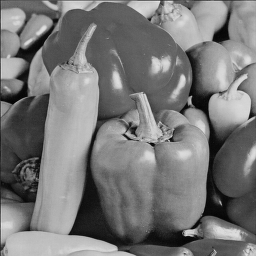

LH, wymiary: (256, 256), typ danych: int16, wartości: -199 - 78


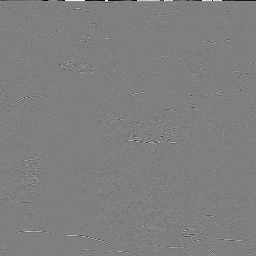

HL, wymiary: (256, 256), typ danych: int16, wartości: -205 - 107


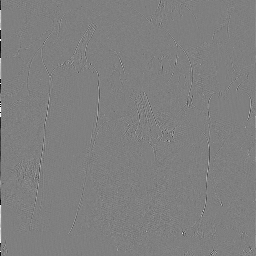

HH, wymiary: (256, 256), typ danych: int16, wartości: -80 - 92


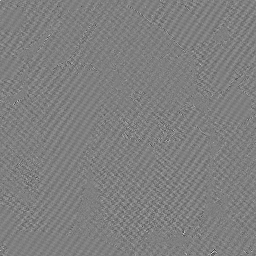

In [75]:
ll, lh, hl, hh = dwt(img_mono)
printi(ll, "LL")
cv_imshow(ll, "LL2")
printi(lh, "LH")
cv_imshow(cv2.multiply(lh, 2), "LH2") ### cv2.multiply() -> zwiększenie kontrastu obrazów 'H', żeby lepiej uwidocznić
printi(hl, "HL")
cv_imshow(cv2.multiply(hl, 2), "HL2")
printi(hh, "HH")
cv_imshow(cv2.multiply(hh, 2), "HH2")

*Wyznaczyć histogramy i obliczyć entropię dla wszystkich pasm.*

H(LL) = 7.5759 
H(LH) = 4.2044 
H(HL) = 4.2610 
H(HH) = 5.3115 
H_śr = 5.3382


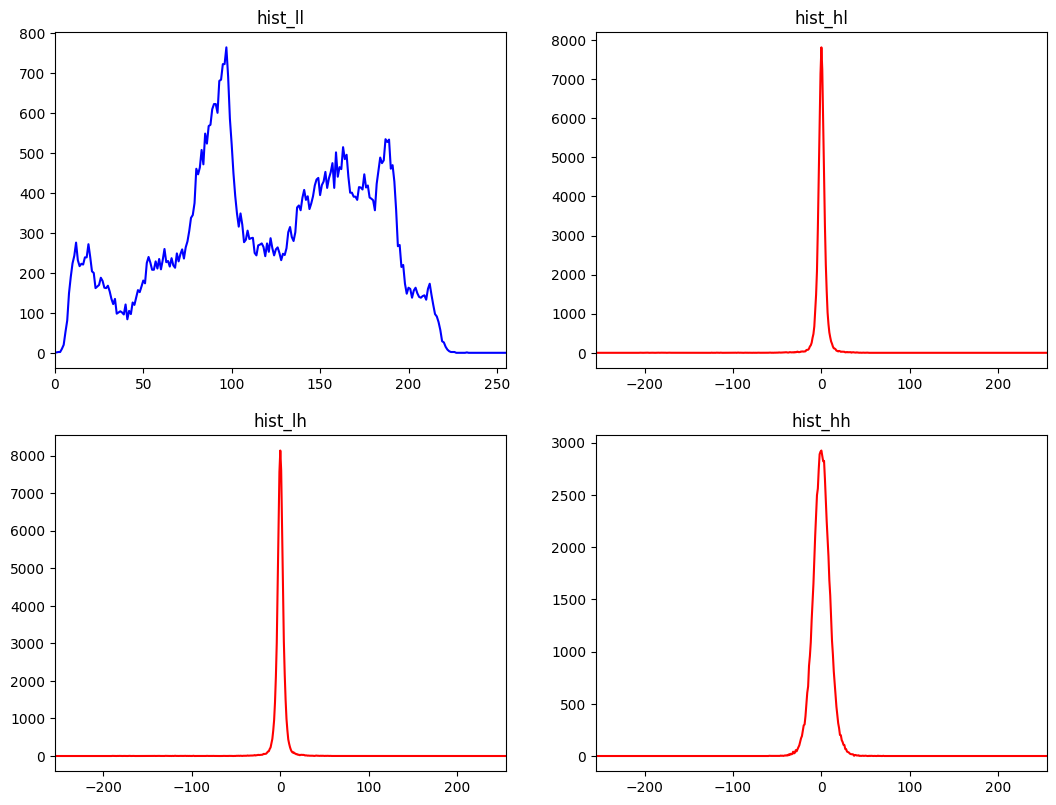

In [76]:
""" Entropia dla obrazów pasmowych """
hist_ll = cv2.calcHist([ll], [0], None, [256], [0, 256]).flatten()
hist_lh = cv2.calcHist([(lh+255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten() ### zmiana zakresu wartości i typu danych ze względu na cv2.calcHist() (jak wcześniej przy obrazach różnicowych)
hist_hl = cv2.calcHist([(hl+255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten()
hist_hh = cv2.calcHist([(hh+255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten()
H_ll = calc_entropy(hist_ll)
H_lh = calc_entropy(hist_lh)
H_hl = calc_entropy(hist_hl)
H_hh = calc_entropy(hist_hh)
print(f"H(LL) = {H_ll:.4f} \nH(LH) = {H_lh:.4f} \nH(HL) = {H_hl:.4f} \nH(HH) = {H_hh:.4f} \nH_śr = {(H_ll+H_lh+H_hl+H_hh)/4:.4f}")

""" Wyświetlenie histogramów - jeden obraz z czterema pod-obrazami """
fig = plt.figure()
fig.set_figheight(fig.get_figheight()*2)
fig.set_figwidth(fig.get_figwidth()*2)
plt.subplot(2, 2, 1)
plt.plot(hist_ll, color="blue")
plt.title("hist_ll")
plt.xlim([0, 255])
plt.subplot(2, 2, 3)
plt.plot(np.arange(-255, 256, 1), hist_lh, color="red")
plt.title("hist_lh")
plt.xlim([-255, 255])
plt.subplot(2, 2, 2)
plt.plot(np.arange(-255, 256, 1), hist_hl, color="red")
plt.title("hist_hl")
plt.xlim([-255, 255])
plt.subplot(2, 2, 4)
plt.plot(np.arange(-255, 256, 1), hist_hh, color="red")
plt.title("hist_hh")
plt.xlim([-255, 255])
plt.show()

>Porównać wyniki (histogram, entropia) uzyskane dla poszczególnych pasm między sobą (czy któreś się wyróżniają i dlaczego?) oraz z wynikami uzyskanymi dla obrazu oryginalnego i obrazu różnicowego.*

Wyróżnia się entropia pasma LL oraz histogram ponieważ to paśmo zawiera najwięcej informacii o obrazku, co jest widoczne na histogramie. Natomiast pasma LH, HL i HH wyglądają podobnie i cechuje je zbliżona entropia. Podobne one są do obrazu różnicowego względem wyglądu oraz entropii.

---

## Obraz barwny

*Obliczyć entropię dla składowych RGB barwnego obrazu testowego.*

image_col, wymiary: (512, 512, 3), typ danych: uint8, wartości: 0 - 237
H(R) = 7.3388 
H(G) = 7.5184 
H(B) = 7.0584 
H_śr = 7.3052


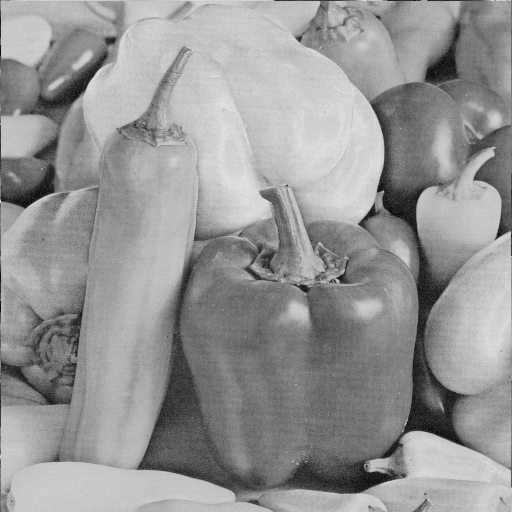

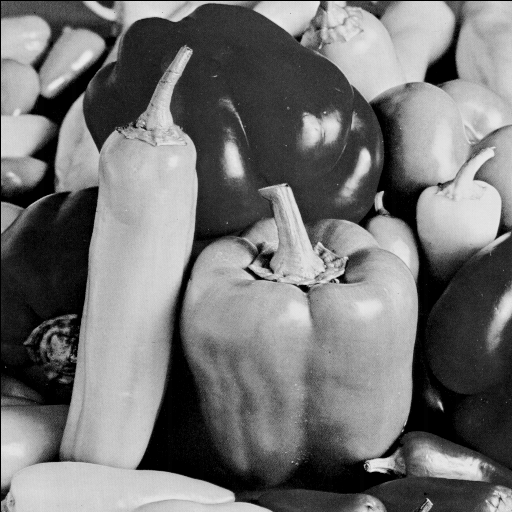

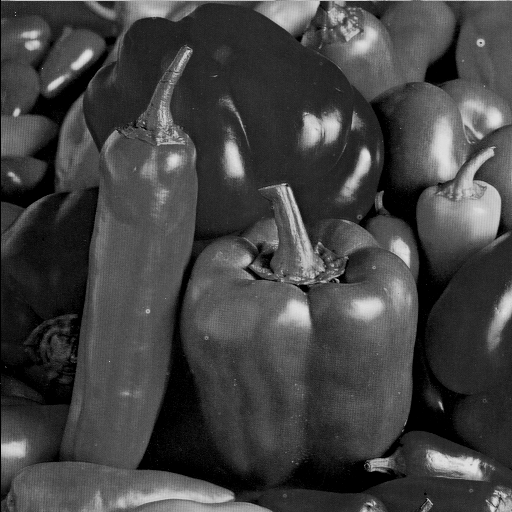

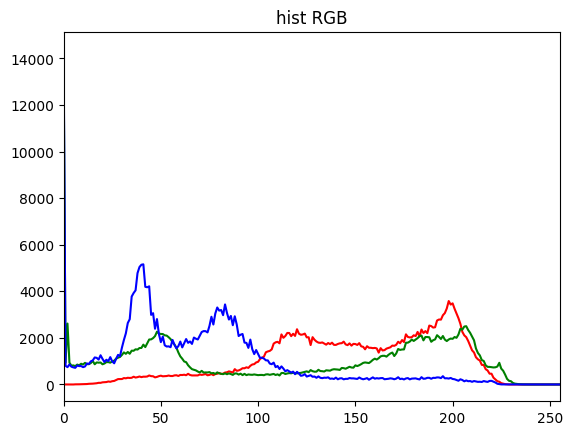

In [77]:
img_col = cv2.imread(img_col_path)
printi(img_col, "image_col")

image_R = img_col[:, :, 2] ### cv2.imread() zwraca obrazy w formacie BGR
image_G = img_col[:, :, 1]
image_B = img_col[:, :, 0]

hist_R = cv2.calcHist([image_R], [0], None, [256], [0, 256]).flatten()
hist_G = cv2.calcHist([image_G], [0], None, [256], [0, 256]).flatten()
hist_B = cv2.calcHist([image_B], [0], None, [256], [0, 256]).flatten()

H_R = calc_entropy(hist_R)
H_G = calc_entropy(hist_G)
H_B = calc_entropy(hist_B)

print(f"H(R) = {H_R:.4f} \nH(G) = {H_G:.4f} \nH(B) = {H_B:.4f} \nH_śr = {(H_R+H_G+H_B)/3:.4f}")

cv_imshow(image_R, "image_R")
cv_imshow(image_G, "image_G")
cv_imshow(image_B, "image_B")
plt.figure()
plt.plot(hist_R, color="red")
plt.plot(hist_G, color="green")
plt.plot(hist_B, color="blue")
plt.title("hist RGB")
plt.xlim([0, 255])
plt.show()

*Dokonać konwersji z RGB do YUV i obliczyć entropię dla składowych YUV. Wyświetlić składowe RGB i YUV. Wyznaczyć histogramy dla wszystkich składowych RGB i YUV.*

image_YUV, wymiary: (512, 512, 3), typ danych: uint8, wartości: 0 - 255
H(Y) = 7.5933 
H(U) = 5.6252 
H(V) = 6.9128 
H_śr = 6.7105


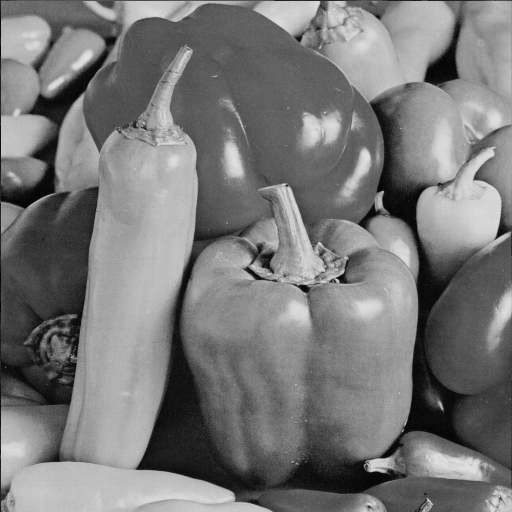

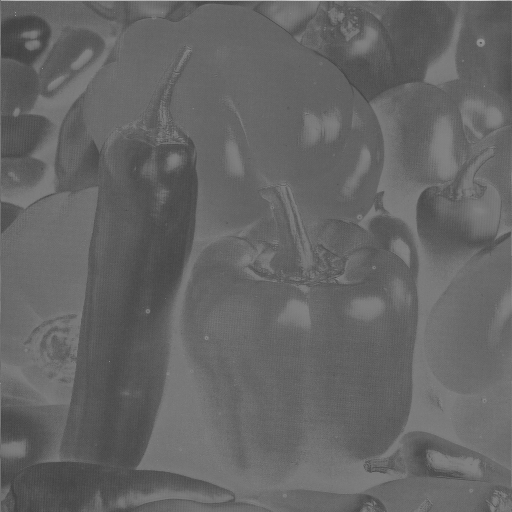

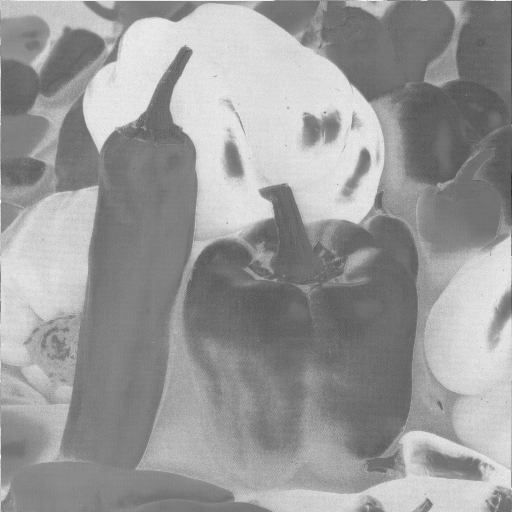

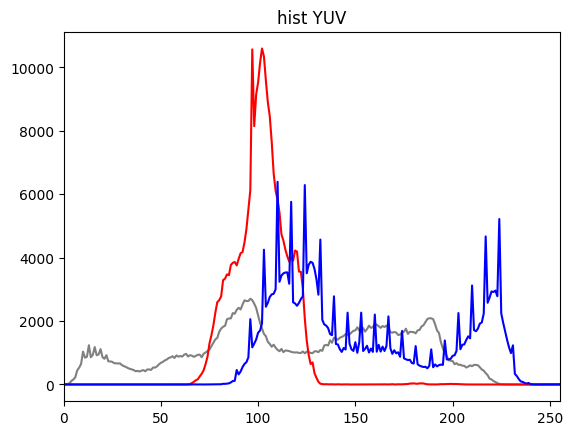

In [78]:
image_YUV = cv2.cvtColor(img_col, cv2.COLOR_BGR2YUV) ### albo: cv2.COLOR_BGR2YUV
printi(image_YUV, "image_YUV")

hist_Y = cv2.calcHist([image_YUV[:, :, 0]], [0], None, [256], [0, 256]).flatten()
hist_U = cv2.calcHist([image_YUV[:, :, 1]], [0], None, [256], [0, 256]).flatten()
hist_V = cv2.calcHist([image_YUV[:, :, 2]], [0], None, [256], [0, 256]).flatten()

H_Y = calc_entropy(hist_Y)
H_U = calc_entropy(hist_U)
H_V = calc_entropy(hist_V)

print(f"H(Y) = {H_Y:.4f} \nH(U) = {H_U:.4f} \nH(V) = {H_V:.4f} \nH_śr = {(H_Y+H_U+H_V)/3:.4f}")

cv_imshow(image_YUV[:, :, 0], "image_Y")
cv_imshow(image_YUV[:, :, 1], "image_U")
cv_imshow(image_YUV[:, :, 2], "image_V")
plt.figure()
plt.plot(hist_Y, color="gray")
plt.plot(hist_U, color="red")
plt.plot(hist_V, color="blue")
plt.title("hist YUV")
plt.xlim([0, 255])
plt.show()

>Porównać wyniki uzyskane dla poszczególnych składowych. Czy dla składowych UV entropia jest mniejsza? Z czego ta mniejsza wartość może wynikać?*

Dla części widma światła o długości fal krótszej niż światło widzialne, entropia jest mniejsza, ponieważ ta część zawiera mniej informacji, co sprawia, że ​​jest łatwiejsza do skompresowania niż część odpowiedzialna za jasność.

>Wyznaczyć zależność zniekształcenia D od przepływności R (liczba bitów przypadającą na jeden piksel obrazu): D = f(R) – tzw. krzywa R-D – dla kodera JPEG. Regulacji stopnia kompresji (przepływności R) należy dokonywać ustawiając wartości parametru ‘quality’ przy zapisie obrazu do pliku. Wartości parametru ‘quality’ należy dobrać tak, aby uzyskać ‘gładkie’ wykresy. Jako miarę zniekształceń należy użyć szczytowy stosunek sygnału do szumu PSNR i błąd średniokwadratowy MSE. Zobrazować zależności na wykresach (oddzielny wykres dla każdej miary).

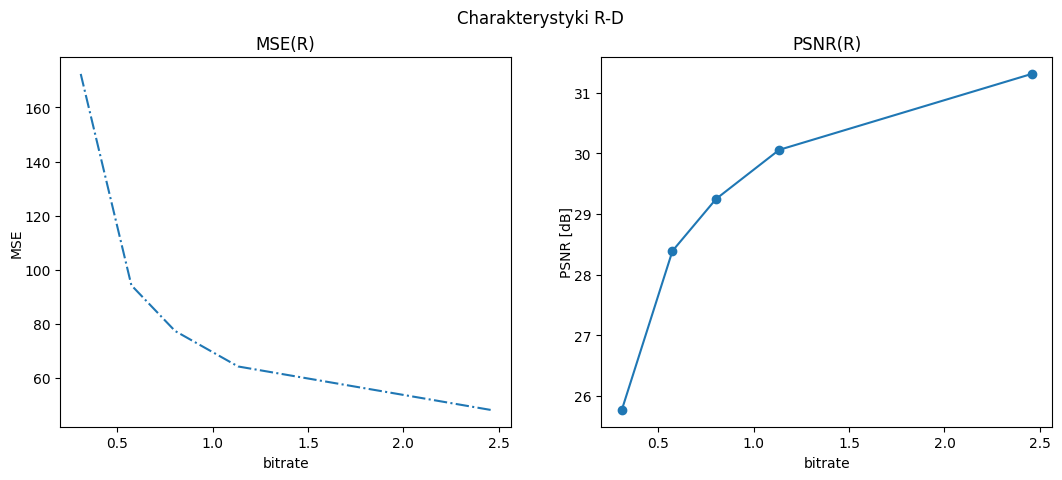

In [79]:
xx = [] ### tablica na wartości osi X -> bitrate
ym = [] ### tablica na wartości osi Y dla MSE
yp = [] ### tablica na wartości osi Y dla PSNR

for quality in [90, 70, 50, 30, 10]: ### wartości dla parametru 'quality' należałoby dobrać tak, aby uzyskać 'gładkie' wykresy...
    out_file_name = f"out_image_q{quality:03d}.jpg"
    """ Zapis do pliku w formacie .jpg z ustaloną 'jakością' """
    cv2.imwrite(out_file_name, img_col, (cv2.IMWRITE_JPEG_QUALITY, quality))
    """ Odczyt skompresowanego obrazu, policzenie bitrate'u i PSNR """
    image_compressed = cv2.imread(out_file_name, cv2.IMREAD_UNCHANGED)
    bitrate = 8*os.stat(out_file_name).st_size/(img_col.shape[0]*img_col.shape[1]) ### image.shape == image_compressed.shape
    mse, psnr = calc_mse_psnr(img_col, image_compressed)
    """ Zapamiętanie wyników do pózniejszego wykorzystania """
    xx.append(bitrate)
    ym.append(mse)
    yp.append(psnr)

""" Narysowanie wykresów """
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth()*2)
plt.suptitle("Charakterystyki R-D")
plt.subplot(1, 2, 1)
plt.plot(xx, ym, "-.")
plt.title("MSE(R)")
plt.xlabel("bitrate")
plt.ylabel("MSE", labelpad=0)
plt.subplot(1, 2, 2)
plt.plot(xx, yp, "-o")
plt.title("PSNR(R)")
plt.xlabel("bitrate")
plt.ylabel("PSNR [dB]", labelpad=0)
plt.show()

Jakość 90%


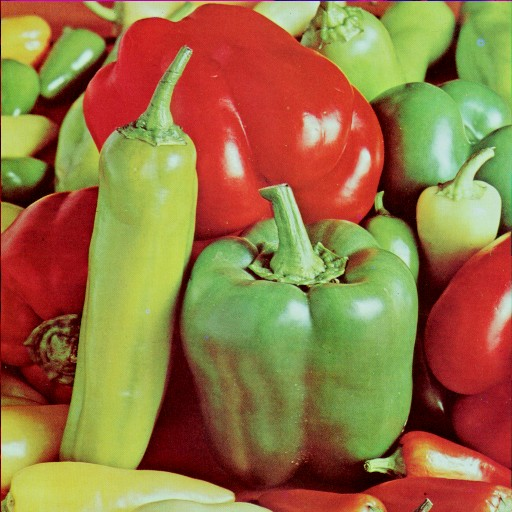

Jakość 70%


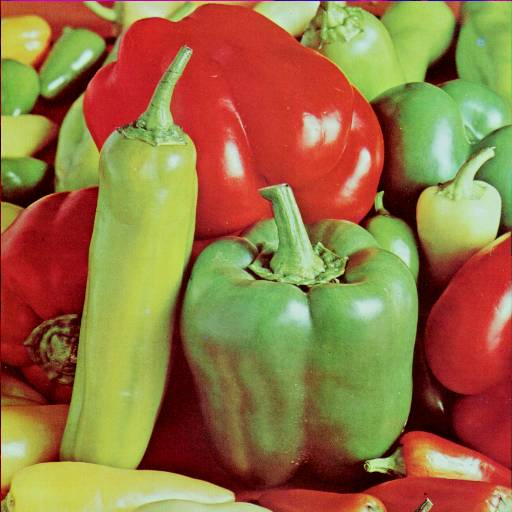

Jakość 50%


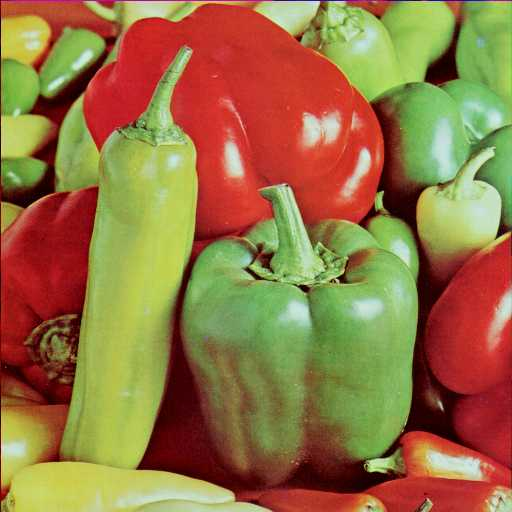

Jakość 30%


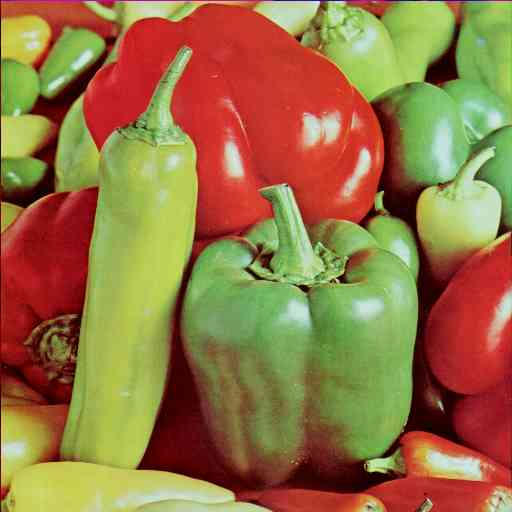

Jakość 10%


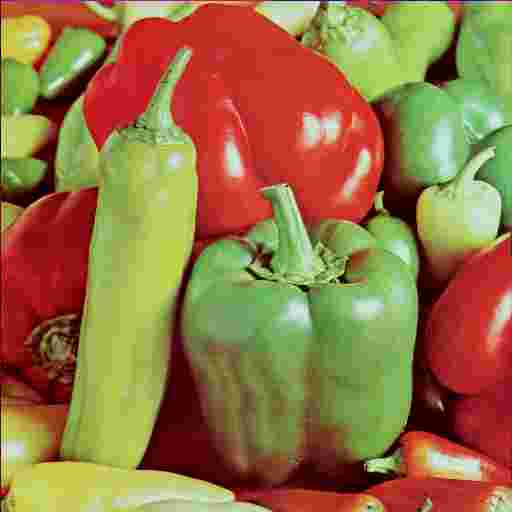

In [80]:
print("Jakość 90%")
display(Image("out_image_q090.jpg"))
print("Jakość 70%")
display(Image("out_image_q070.jpg"))
print("Jakość 50%")
display(Image("out_image_q050.jpg"))
print("Jakość 30%")
display(Image("out_image_q030.jpg"))
print("Jakość 10%")
display(Image("out_image_q010.jpg"))

>Dokonać subiektywnej oceny obrazów zrekonstruowanych (według własnej skali ocen, np.: jakość doskonała, bardzo dobra, dobra, średnia, kiepska, zła, bardzo zła, itp., lub: zniekształcenia niewidoczne, lekko widoczne, widoczne, bardzo widoczne, nie do przyjęcia, itp.) i zamieścić te oceny w sprawozdaniu (niekoniecznie dla każdego obrazu wynikowego osobno, raczej ‘zgrupować’ oceny dla pewnych zakresów przepływności).

- Jakości do 30 są złe. Widać na nich duże prostokąty złożone z pikseli tego samego koloru.
- Jakości od 30 do 70 są dobre. Ale są widoczne zniekształcenie.
- Jakości od 70 do 100 są wspaniałe. Dobrze widać na nich dobrze wszystkie szczegóły.

In [81]:
image = cv2.imread(img_col_path, cv2.IMREAD_UNCHANGED)
bitrate = 8*os.stat(img_col_path).st_size/(image.shape[0]*image.shape[1])
print(f"bitrate: {bitrate:.4f}")

image = cv2.imread("out_image_q010.jpg", cv2.IMREAD_UNCHANGED)
bitrate = 8*os.stat("out_image_q010.jpg").st_size/(image.shape[0]*image.shape[1])
print(f"bitrate: {bitrate:.4f}")

image = cv2.imread("out_image_q050.jpg", cv2.IMREAD_UNCHANGED)
bitrate = 8*os.stat("out_image_q050.jpg").st_size/(image.shape[0]*image.shape[1])
print(f"bitrate: {bitrate:.4f}")

image = cv2.imread("out_image_q090.jpg", cv2.IMREAD_UNCHANGED)
bitrate = 8*os.stat("out_image_q090.jpg").st_size/(image.shape[0]*image.shape[1])
print(f"bitrate: {bitrate:.4f}")

bitrate: 15.5011
bitrate: 0.3081
bitrate: 0.8026
bitrate: 2.4575


>Porównać stopnie kompresji uzyskiwane dla kodera JPEG ze stopniem kompresji uzyskanym dla kodera PNG (pamiętając, że w pierwszej części laboratorium wykorzystywany był monochromatyczny obraz PNG, a kompresja JPEG była wykonywana dla obrazu barwnego; ewentualnie wyliczyć przepływność bitową dla obrazu barwnego skompresowanego koderem PNG).

Koder JPEG potrafi skompresować obraz w sposób bardziej efektywny niż koder PNG, ponieważ używa kompresji stratnej - czyli nie przechowuje całej informacji o obrazie. W odróżnieniu od niego, koder PNG zachowuje wszystkie informacje, co powoduje mniejszy stopień kompresji.